In [1]:
import numpy as np
from sklearn.model_selection import KFold, StratifiedKFold
import pandas as pd
from matplotlib import pyplot as plt
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from lightgbm import LGBMClassifier, plot_importance
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder 
%matplotlib inline

In [2]:
train = pd.read_csv("../Data/music-genre-dataset/train_new_feat.csv")
train.head()

,track id,chroma_sftf,rolloff,zero_crossing_rate,rmse,flux,contrast,flatness,sample_silence,mfcc_0,...,power,joyful_activation,tension,sadness,mood,liked,disliked,age,gender,mother tongue
0,1,0.168468,5243.018296,0.115553,0.021488,1.004327,27.502646,0.00545,0,-404.308594,...,0,0,0,1,3,0,0,30,0,English
1,1,0.168468,5243.018296,0.115553,0.021488,1.004327,27.502646,0.00545,0,-404.308594,...,0,0,0,1,1,1,0,33,0,Russian
2,1,0.168468,5243.018296,0.115553,0.021488,1.004327,27.502646,0.00545,0,-404.308594,...,0,0,0,1,4,0,1,51,0,English
3,1,0.168468,5243.018296,0.115553,0.021488,1.004327,27.502646,0.00545,0,-404.308594,...,0,0,0,0,3,0,0,21,1,English
4,1,0.168468,5243.018296,0.115553,0.021488,1.004327,27.502646,0.00545,0,-404.308594,...,0,0,0,1,3,0,0,60,1,English


In [3]:
#Drop useless features
useless = [ ' mother tongue', ' amazement',
       ' solemnity', ' tenderness', ' nostalgia', ' calmness', ' power',
       ' joyful_activation', ' tension', ' sadness', ' age', ' gender', ' mood', ' liked', ' disliked', 'sample_silence']
train  = train.drop(useless, 1)

In [4]:
# Drop Duplicates  rows to avoid overfiting
train = train.drop_duplicates()

In [5]:
LABEL = 'genre'
# Encode LABEL
print(f' original target value: {train[LABEL].unique()}')
lb = LabelEncoder()
train[LABEL] = lb.fit_transform(train[LABEL])
print(f' encoded target value: {train[LABEL].unique()}')

 original target value: [0 1 2 3]
 encoded target value: [0 1 2 3]


In [10]:
#save lb 
filename = f'../model_saved/LB_genre.sav'
pickle.dump(lb, open(filename, 'wb'))

In [6]:
#Get list of base Features
FEATURES = train.columns.drop(['track id', LABEL])
print(f"base features: {FEATURES.tolist()}")

base features: ['chroma_sftf', 'rolloff', 'zero_crossing_rate', 'rmse', 'flux', 'contrast', 'flatness', 'mfcc_0', 'mfcc_1', 'mfcc_2', 'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7', 'mfcc_8', 'mfcc_9', 'mfcc_10', 'mfcc_11', 'mfcc_12', 'mfcc_13', 'mfcc_14', 'mfcc_15', 'mfcc_16', 'mfcc_17', 'mfcc_18', 'mfcc_19', 'tempo']


In [7]:
# Model Validation 
epochs = 5
kf = StratifiedKFold(n_splits=epochs, shuffle=True, random_state=1997)  # 30, n_split 3
X_train = train[FEATURES] 
y_train = train[LABEL]
y_oof = np.zeros([X_train.shape[0], 4])
i = 0
METRICS = []
for tr_idx, val_idx in kf.split(X_train, y_train):
    X_tr, X_vl = X_train.iloc[tr_idx, :], X_train.iloc[val_idx, :]
    y_tr, y_vl = y_train.iloc[tr_idx], y_train.iloc[val_idx]
    model = LGBMClassifier(random_state=47)  
    model.fit(X_tr, y_tr) 
    y_pred = model.predict_proba(X_vl)
    y_oof[val_idx, :] = y_pred
    i += 1
    acc = roc_auc_score(pd.get_dummies(y_vl), y_pred, multi_class='ovr')
    print(f"Fold #{i} AUC : {round(acc, 2)}")
metric = roc_auc_score(pd.get_dummies(y_train), y_oof, multi_class='ovr')
print(f"Full AUC  : {round(metric, 2)}")

Fold #1 AUC : 0.88
Fold #2 AUC : 0.84
Fold #3 AUC : 0.87
Fold #4 AUC : 0.83
Fold #5 AUC : 0.81
Full AUC  : 0.85


In [9]:
import pickle
filename = f'../model_saved/Music_Genre_Clf.sav'
pickle.dump(model, open(filename, 'wb'))

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

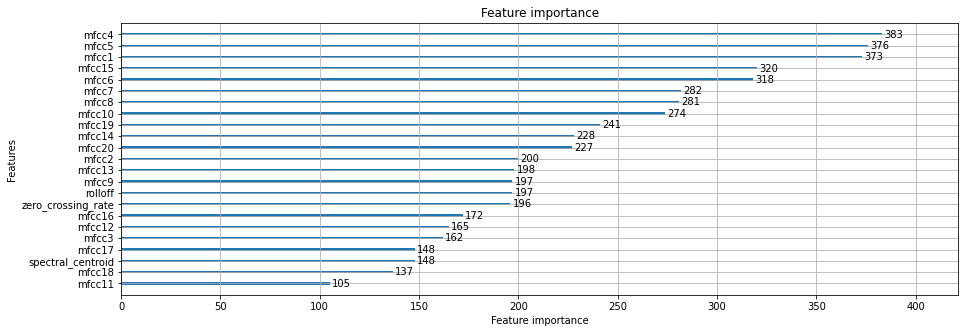

In [10]:
#Plot Features importances
plot_importance(model, figsize=(15, 5))